# Quickstart with LanceDB Cloud
Welcome to LanceDB Cloud!

In this notebook, we show how to implement efficient semantic search using LanceDB Cloud. You'll learn how to:

📥 Connect with LanceDB Cloud

🔧 Ingest a dataset into LanceDB

🚀 Build a vector index and perform semantic searches



## Step 1: Install LanceDB

In [ ]:
! pip install lancedb datasets

## Step 2: Obtain the API key from the [dashboard](https://cloud.lancedb.com) and Connect to LanceDB Cloud


*  Get the `db uri`

`db uri` starts with `db://`, which can be obtained from the project page on the dashboard. In the following example, `db uri` is `db://test-sfifxz`.

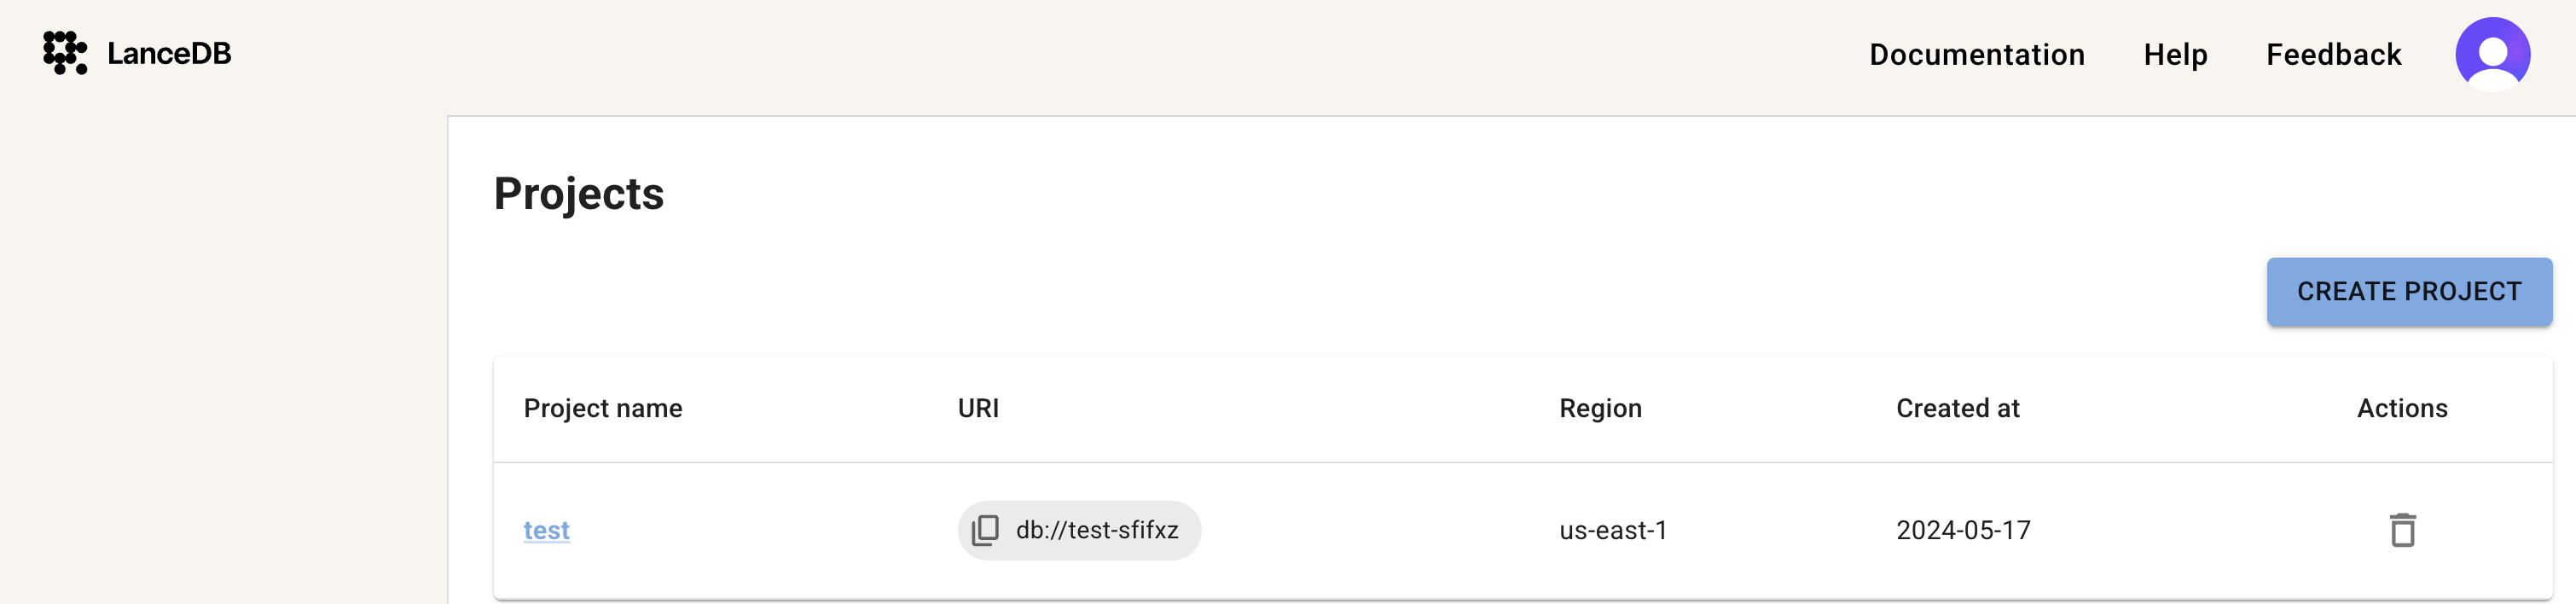

*  Get the `API Key`
Obtain a LanceDB Cloud API key by clicking on the `GENERATE API KEY` from the `table` page.

💡 Copy the code block for connecting to LanceDB Cloud that is shown at the last step of API key generation.
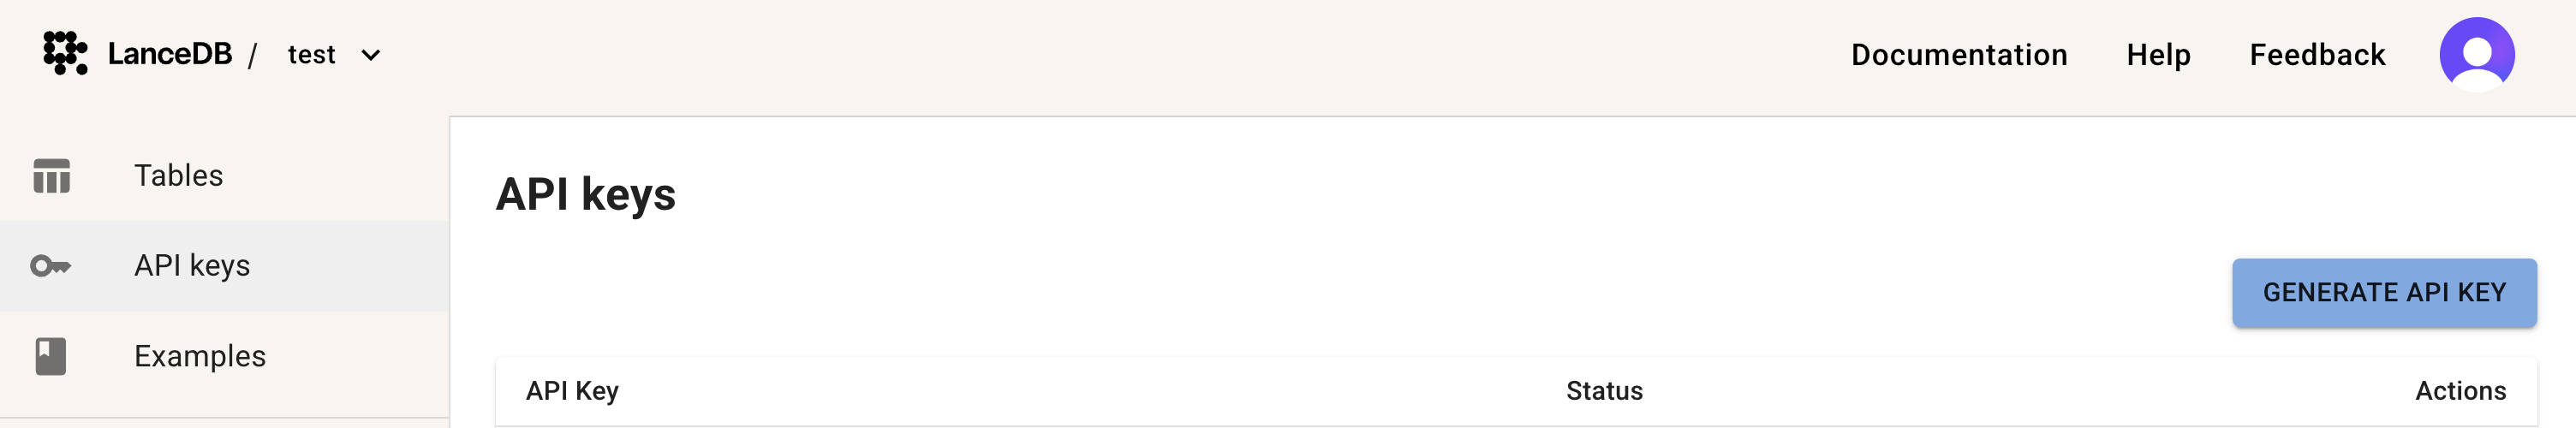

*  Connect to LanceDB Cloud

Copy and paste the `db uri` and the `api key` from the previous steps, or directly paste the code block for LanceDB Cloud connection.

In [21]:
uri = "db://your-db-uri"  # @param {type:"string"}

In [22]:
api_key = "sk_..."  # @param {type:"string"}

In [23]:
import lancedb

api_key = api_key
uri = uri

db = lancedb.connect(
  uri=uri,
  api_key=api_key,
  region="us-east-1"
)

# alternatively, you can paste the code block for LanceDB Cloud connection here
# db = lancedb.connect(
#   uri="db://your-db-uri",
#   api_key="sk_...",
#   region="us-east-1"
# )

## Step 3: Ingest Data

We use the `ag_news` dataset from [HuggingFace](https://huggingface.co/datasets/sunhaozhepy/ag_news_sbert_keywords_embeddings), which includes 768-dimensional precomputed embeddings. To optimize performance, we extract the first 3,000 rows from the test split for this example.

In [7]:
from datasets import load_dataset
import pyarrow as pa

sample_dataset = load_dataset("sunhaozhepy/ag_news_sbert_keywords_embeddings", split="test[:3000]")
vector_dim = len(sample_dataset[0]["keywords_embeddings"])
print(sample_dataset.column_names)
print(sample_dataset[:5])

table_name = "lancedb-cloud-quickstart"
table = db.create_table(table_name, data=sample_dataset, mode="overwrite")

# convert list to fixedsizelist on the vector column
table.alter_columns(dict(path="keywords_embeddings", data_type=pa.list_(pa.float32(), vector_dim)))

['text', 'label', 'keywords', 'keywords_embeddings']
{'text': ["Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.", 'The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\\privately funded suborbital space flight, has officially announced the first\\launch date for its manned rocket.', 'Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.', "Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he

ℹ️ There are various ways to specify the table schema. More details can be found in our [documentation](https://docs.lancedb.com/core/ingestion).

## Step 4: Create a vector index

We will create a vector index on the `keywords_embeddings` column.



In [ ]:
table.create_index("cosine", vector_column_name="keywords_embeddings")

⚠️ WARNING: `create_index` is asynchonous so it returns when indexing is in progress. We provide the `list_indices` and `index_stats` APIs to check index status. The index name is formed by appending “_idx” to the column name. Note that `list_indices` will not return any information until the index has fully ingested and indexed all available data.

In [ ]:
import time

def wait_for_index(table, index_name):
  POLL_INTERVAL = 10
  while True:
      indices = table.list_indices()

      if indices and any(index.name == index_name for index in indices):
          break
      print(f"⏳ Waiting for {index_name} to be ready...")
      time.sleep(POLL_INTERVAL)

  print(f"✅ {index_name} is ready!")

index_name = "keywords_embeddings_idx"
wait_for_index(table, index_name)
print(table.index_stats(index_name))
# IndexStatistics(num_indexed_rows=3000, num_unindexed_rows=0, index_type='IVF_PQ', distance_type='cosine', num_indices=None)

## Step 5: Query

Let's perform a search. Note here that only the `text` and `keywords` columns will be returned



In [12]:
query_dataset = load_dataset("sunhaozhepy/ag_news_sbert_keywords_embeddings", split="test[5000:5001]")
print(query_dataset[0]["keywords"])
query_embed = query_dataset["keywords_embeddings"][0]

table.search(query_embed).select(["text", "keywords"]).limit(5).to_pandas()

toyota, profit, carmaker


,text,keywords,_distance
0,Toyota: Some security firms promise too much I...,"toyota, security, firms",0.623934
1,Toyota to open south China plant Japan carmake...,"toyota, china, japan",0.764812
2,The Hunt for a Hybrid The Aug. 23 front-page a...,"prius, civic, toyota",0.792181
3,"Update 8: Ford, GM Set Production Cuts on Sale...","ford, automakers, gm",0.850840
4,Corus makes first profit as UK steel plants re...,"corus, profit, turnaround",0.876934


## Step 6: Cleanup

We can now delete the table.


In [ ]:
db.drop_table(table_name)

🎉 Congrats! You just built your first semantic search application with LanceDB Cloud!